In [1]:
"""
Created on Sun Oct  3 19:26:11 2021

@author: franc


Un ejemplo simple de NLP

En este script veremos un ejemplo simple de cómo analizar texto usando NLP
1er paso: usa un tokenizer en el texto
"""

'\nCreated on Sun Oct  3 19:26:11 2021\n\n@author: franc\n\n\nUn ejemplo simple de NLP\n\nEn este script veremos un ejemplo simple de cómo analizar texto usando NLP\n1er paso: usa un tokenizer en el texto\n'

In [2]:
import tensorflow as tf
import numpy as np
import os
from tensorflow import keras

In [3]:
shakespeare_url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
filepath = keras.utils.get_file("shakespeare.txt", shakespeare_url)
with open(filepath) as f:
    shakespeare_text = f.read()

1130496/1115394 [==============================] - 0s 0us/step


In [4]:
tokenizer = keras.preprocessing.text.Tokenizer(char_level=True)     #a nivel de char porque iremos prediciendo char por char
tokenizer.fit_on_texts(shakespeare_text)

#Y lo aplicamos al texto

[encoded] = np.array(tokenizer.texts_to_sequences([shakespeare_text])) - 1     #para que empieze desde 0 en vez de 1


In [5]:
datasize = tokenizer.document_count
print(datasize)

train_size = datasize * 90 // 100 #90% train size

#y creamos el dataset en formato Dataset

dataset = tf.data.Dataset.from_tensor_slices(encoded[:train_size])

1115394


In [6]:
#Ahora creamos sub-segmentos de la secuencia completa del train set

n_steps = 100 #secuencias de largo n_steps
window_length = n_steps + 1 #el target será el  nsteps+1avo elemento siguiente

dataset = dataset.window(window_length, shift=1, drop_remainder = True )

In [7]:
#Ahora necesitamos convertir el dataset, que es objeto "WindowsDataset", en un normal dataset.
# Esto lo hacemos con flat_map, pasa de nested windows to windows, y batch crea cada samples de largo window_length

dataset = dataset.flat_map(lambda window: window.batch(window_length))


#Y ahora preparamos la data para entrenamiento

BATCH = 32
dataset = dataset.shuffle(10000).batch(BATCH)
dataset = dataset.map(lambda window: (window[:, :-1], window[:, 1:]))
#el sample son todos los n_steps chars, y el test es lo mismo shifted por un char hacia adelante

#Ahora tenemos que hacer encoding. Por simplicidad, one-hot encoding
max_id = len(tokenizer.word_index) # número de characteres distintos
print(max_id)
dataset = dataset.map(lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch))
dataset = dataset.prefetch(1) #prefetch para eficiencia

39


In [8]:
#veamos un ejemplo de la data

for xsample, ysample in dataset.take(1):
    print(xsample.shape)    #(batch_size, window_size, # features/onehotencoded)
    print('\n')
    print(ysample.shape)
    

(32, 100, 39)


(32, 100)


In [9]:
model = keras.models.Sequential([
    keras.layers.GRU(128, return_sequences=True, input_shape = [None, max_id],
                     dropout = 0.2),
    keras.layers.GRU(128, return_sequences=True, input_shape = [None, max_id],
                     dropout = 0.2),
    keras.layers.Dense(max_id, activation = 'softmax')
        ])

model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, None, 128)         64896     
_________________________________________________________________
gru_1 (GRU)                  (None, None, 128)         99072     
_________________________________________________________________
dense (Dense)                (None, None, 39)          5031      
Total params: 168,999
Trainable params: 168,999
Non-trainable params: 0
_________________________________________________________________


In [10]:
#Probemos con 3 epocas para no alargar el tiempo de training
history = model.fit(dataset, epochs = 3)

Epoch 1/3
31368/31368 [==============================] - 1589s 50ms/step - loss: 1.6180
Epoch 2/3
31368/31368 [==============================] - 1573s 50ms/step - loss: 1.5377
Epoch 3/3
31368/31368 [==============================] - 1588s 51ms/step - loss: 1.5168


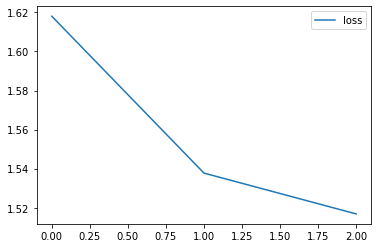

In [11]:
import pandas as pd
pd.DataFrame(history.history).plot()


In [12]:
def preprocess(texts):
    X = np.array(tokenizer.texts_to_sequences(texts)) - 1
    return tf.one_hot(X, max_id)

#Let's see an example
X_new = preprocess(["How are yo"])
#Y_pred = model.predict_classes(X_new)
Y_pred = np.argmax(model(X_new), axis=-1)
tokenizer.sequences_to_texts(Y_pred + 1)[0][-1] # 1st sentence, last char


'u'

It works! :)